In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
# Install dependencies

!git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch
%pip install git+https://github.com/crowsonkb/k-diffusion

Cloning into 'v-diffusion-pytorch'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (49/49), done.
Receiving objects: 100% (168/168), 35.25 KiB | 11.75 MiB/s, done.
remote: Total 168 (delta 87), reused 77 (delta 62), pack-reused 55 (from 1)
Resolving deltas: 100% (103/103), done.
  Cloning https://github.com/crowsonkb/k-diffusion to /tmp/pip-req-build-co5lmfm0
  Running command git clone --filter=blob:none --quiet https://github.com/crowsonkb/k-diffusion /tmp/pip-req-build-co5lmfm0
  Resolved https://github.com/crowsonkb/k-diffusion to commit 21d12c91ad4550e8fcf3308ff9fe7116b3f19a08
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Download the diffusion model
# SHA-256: 4fc95ee1b3205a3f7422a07746383776e1dbc367eaf06a5b658ad351e77b7bda

!mkdir v-diffusion-pytorch/checkpoints
!curl -L --http1.1 https://the-eye.eu/public/AI/models/v-diffusion/cc12m_1_cfg.pth > v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2300M  100 2300M    0     0  2495k      0  0:15:43  0:15:43 --:--:-- 2970k


In [3]:
# Imports

import gc
import math
import sys

import clip
from IPython import display
import k_diffusion as K
import torch
from torch import nn
from torchvision import utils
from torchvision.transforms import functional as TF
from tqdm.notebook import trange, tqdm

sys.path.append('/content/v-diffusion-pytorch')

from diffusion import get_model

In [4]:
# Load the models

inner_model = get_model('cc12m_1_cfg')()
_, side_y, side_x = inner_model.shape
inner_model.load_state_dict(torch.load('v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth', map_location='cpu'))
inner_model = inner_model.half().cuda().eval().requires_grad_(False)
model = K.external.VDenoiser(inner_model)
clip_model = clip.load(inner_model.clip_model, jit=False, device='cpu')[0]

<ipython-input-4-eb23e18c773f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inner_model.load_state_dict(torch.load('v-diffusion-pytorch/checkpoints/cc12m_1_cfg.pth', map

In [14]:

prompt = 'Dog playing'
weight = 5
n_images = 4
steps =   50
seed = 0
display_every =   10

<ipython-input-15-88efd3b7c473>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  model_wrap = CFGDenoiser(torch.cuda.amp.autocast()(model), weight)


  0%|          | 0/50 [00:00<?, ?it/s]

Step 0 of 50, sigma 160:


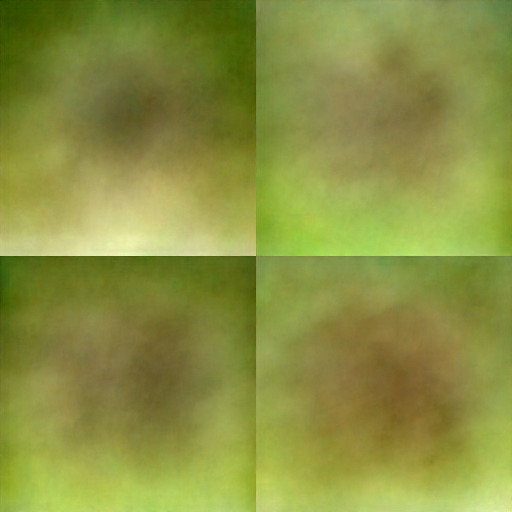


Step 10 of 50, sigma 50.0848:


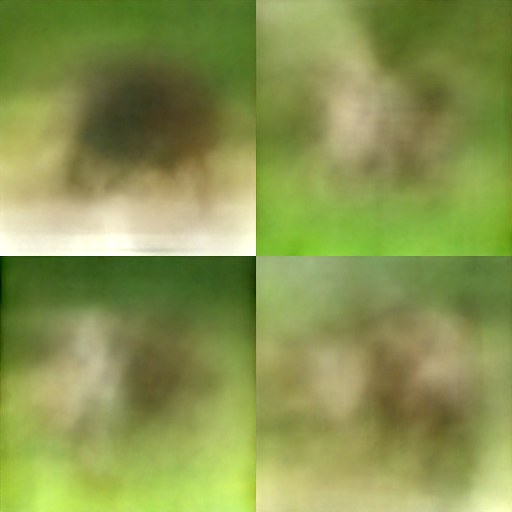


Step 20 of 50, sigma 12.4342:


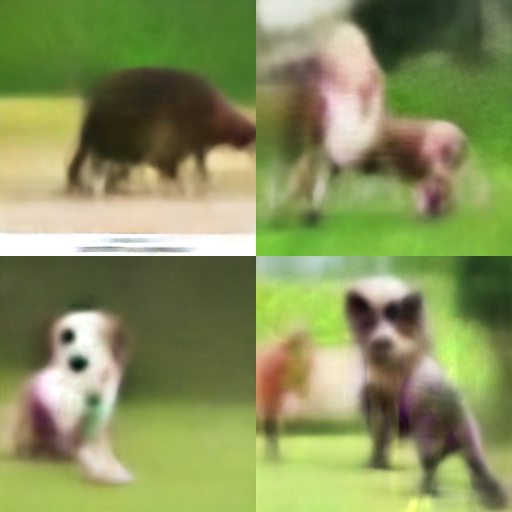


Step 30 of 50, sigma 2.17965:


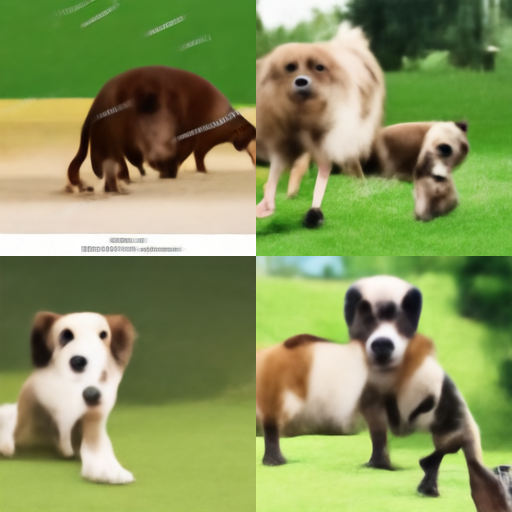


Step 40 of 50, sigma 0.213524:


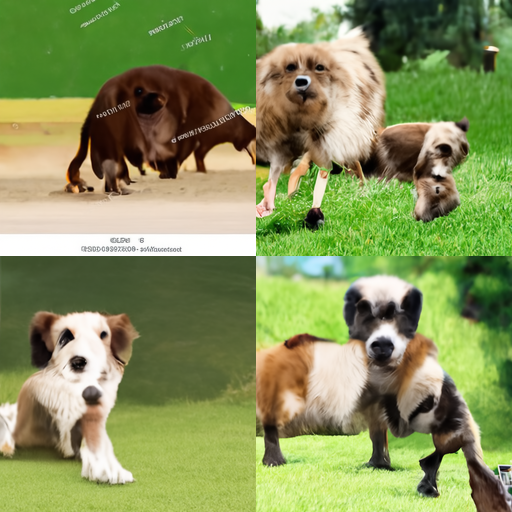


Done!


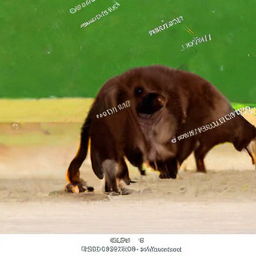

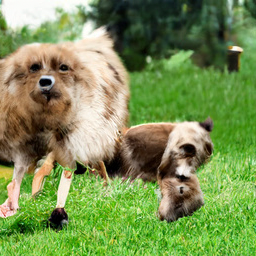

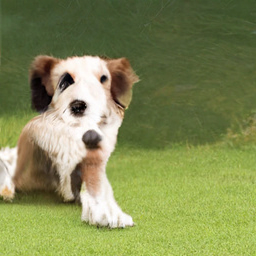

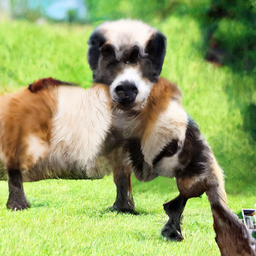

In [15]:
target_embed = clip_model.encode_text(clip.tokenize(prompt)).float().cuda()


class CFGDenoiser(nn.Module):
    def __init__(self, model, cond_scale):
        super().__init__()
        self.inner_model = model
        self.cond_scale = cond_scale

    def forward(self, x, sigma, clip_embed):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        clip_embed_in = torch.cat([torch.zeros_like(clip_embed), clip_embed])
        uncond, cond = self.inner_model(x_in, sigma_in, clip_embed=clip_embed_in).chunk(2)
        return uncond + (cond - uncond) * self.cond_scale


def callback(info):
    if info['i'] % display_every == 0:
        nrow = math.ceil(info['denoised'].shape[0] ** 0.5)
        grid = utils.make_grid(info['denoised'], nrow, padding=0)
        tqdm.write(f'Step {info["i"]} of {steps}, sigma {info["sigma"]:g}:')
        display.display(K.utils.to_pil_image(grid))
        tqdm.write(f'')


def run():
    gc.collect()
    torch.cuda.empty_cache()
    torch.manual_seed(seed)
    sigmas = K.sampling.get_sigmas_karras(steps, 1e-2, 160, device='cuda')
    x = torch.randn([n_images, 3, side_y, side_x], device='cuda') * sigmas[0]
    model_wrap = CFGDenoiser(torch.cuda.amp.autocast()(model), weight)
    extra_args = {'clip_embed': target_embed.repeat([n_images, 1])}
    outs = K.sampling.sample_lms(model_wrap, x, sigmas, extra_args=extra_args, callback=callback)
    tqdm.write('Done!')
    for i, out in enumerate(outs):
        filename = f'out_{i}.png'
        K.utils.to_pil_image(out).save(filename)
        display.display(display.Image(filename))


run()